In [1]:
%load_ext autoreload
%autoreload 2

In [43]:
import gtc_functions

import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [51]:
# TODO: better common path solution. Lisanne's use of Owen's functions? Cambridge-hosted data server?
google_drive_personal_key = '/Users/orlandotimmerman/Library/CloudStorage/GoogleDrive-rt582@cam.ac.uk/.shortcut-targets-by-id/132Xl9yWOGKPM7ybLH0oa9c3dJGYrXkjC/'

In [52]:
### LOAD IN RELEVANT DFS

# xbd observation points
df_xbd_points_path = google_drive_personal_key + 'datasets/xBD_data/xbd_points_posthurr_reformatted.pkl'
df_xbd_points = pd.read_pickle(df_xbd_points_path)
# noaa 6-hourly
df_noaa_pkl_path = google_drive_personal_key + 'datasets/EFs/weather_data/noaa_hurricanes.pkl'
df_noaa_weather = pd.read_pickle(df_noaa_pkl_path)
# weather stations
df_stations_pkl_path = google_drive_personal_key + 'datasets/EFs/weather_data/weather_stations.pkl'
df_stations = pd.read_pickle(df_stations_pkl_path)
# noaa six-hourly closest to each xbd point
df_noaa_xbd_pkl_path = google_drive_personal_key + 'datasets/EFs/weather_data/xbd_obs_noaa_six_hourly.pkl'
df_noaa_xbd_weather = pd.read_pickle(df_noaa_xbd_pkl_path)
# weather stations infor for each xbd point
df_stations_xbd_pkl_path = google_drive_personal_key + 'datasets/EFs/weather_data/xbd_stations_info.pkl'
df_stations_xbd = pd.read_pickle(df_stations_xbd_pkl_path)

## Visualise stations data availability

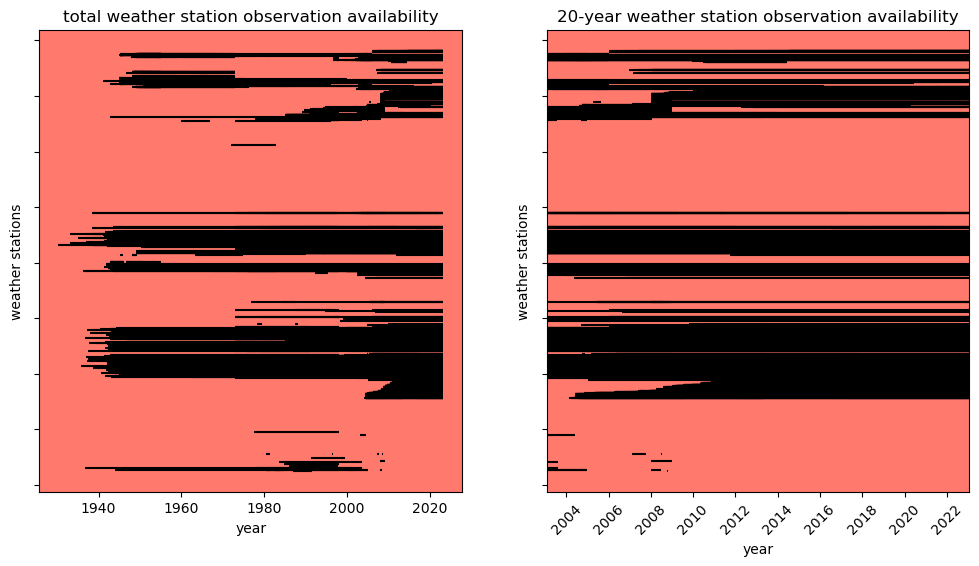

In [53]:
# set number of stations to include (helps visualise data availability): -1 = all
num_stations = -1

fig, axs = plt.subplots(1,2,figsize=[12,6]);
axs = axs.ravel()

for i in range(len(axs)):
    axs[i].set_xlabel('year'), axs[i].set_ylabel('weather stations')
    axs[i].hlines(df_stations.index[:num_stations], 
        df_stations.begin[:num_stations], df_stations.end[:num_stations],
    color='k')

    # formatting
    axs[i].set_facecolor('xkcd:salmon')
    axs[i].set_yticklabels([])

axs[0].set_title('total weather station observation availability');

axs[1].set_xlim((max(df_stations.end[:num_stations])-pd.Timedelta(20*365,'d')),max(df_stations.end[:num_stations]));
axs[1].tick_params(axis='x', labelrotation=45)
axs[1].set_title('20-year weather station observation availability');

### Plot geographical distribution of weather stations

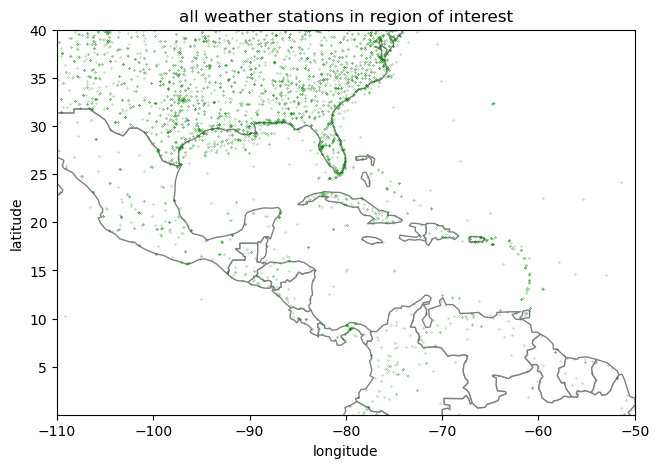

In [5]:
### PLOT WEATHER STATIONS

gdf_stations = gpd.GeoDataFrame(df_stations,geometry=gpd.points_from_xy(df_stations.lon,df_stations.lat))

# fetch worldmap and format plot size
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
plt.rcParams['figure.figsize'] = [13, 7]

fig, ax = plt.subplots(figsize=[12,5]);
ax.set_xlabel('longitude'), ax.set_ylabel('latitude')
world.plot(ax=ax,color='white',edgecolor='grey')
gdf_stations.plot(ax=ax,color='green',markersize=0.05,alpha=0.8);

# formatting
ax.set_xlim([min(gdf_stations['lon']),max(gdf_stations['lon'])]);
ax.set_ylim([min(gdf_stations['lat']),max(gdf_stations['lat'])]);
ax.set_title('all weather stations in region of interest');


## Visualise hurricane data

In [ ]:
# TODO: graphs
# historic trend of hurricane events (for powerpoint)

## Visualise hurricane tracks for xBD events

In [6]:
# restrict hurricanes df to xbd events
xbd_hurricane_names = ['MICHAEL','MATTHEW','FLORENCE','HARVEY']
df_xbd_hurricanes_noaa = gtc_functions.mostRecentEventsByName(df_noaa_weather,xbd_hurricane_names)

# number of 6-hour intervals spanning xbd hurricanes in the Atlantic
num_6s = len(df_xbd_hurricanes_noaa)
print('number of 6-hour intervals spanning xbd hurricanes in the Atlantic: ', num_6s)
# number of 1-hour intervals spanning hurricanes in the Atlantic
# approximate since coarse (may have a couple of hours of weather caused the same
# storm on either end)
num_hourly = num_6s * 6
print('approximate number of 1-hour intervals spanning xbd hurricanes in the Atlantic: ', num_hourly)

number of 6-hour intervals spanning xbd hurricanes in the Atlantic:  241
approximate number of 1-hour intervals spanning xbd hurricanes in the Atlantic:  1446


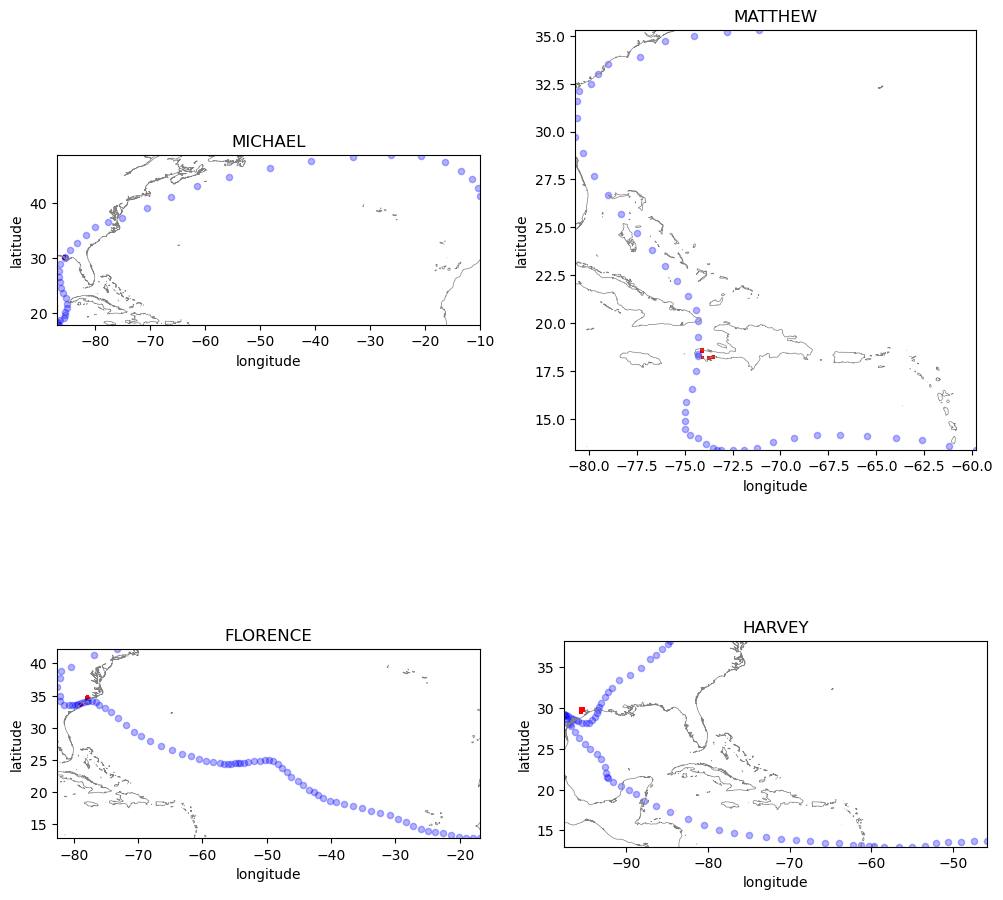

In [57]:
### PLOT HURRICANE TRACKS BY EVENT

# plot xbd locations and relevant NOAA datapoints
fig, axs = plt.subplots(2,2,figsize=[12,12]);
axs = axs.ravel()

# fetch worldmap and format plot size
# TODO: common path – and standardise with what others are using.
# Credit: World Bank https://datacatalog.worldbank.org/search/dataset/0038272/World-Bank-Official-Boundaries
gdf_coastlines = gpd.read_file(google_drive_personal_key + 'datasets/EFs/weather_data/WB_Coastlines.geojson')
plt.rcParams['figure.figsize'] = [13, 7]

for i,name in enumerate(xbd_hurricane_names):
    axs[i].set_title(f'{name}')
    axs[i].set_xlabel('longitude'), axs[i].set_ylabel('latitude')
    gdf_coastlines.plot(ax=axs[i],color='grey',alpha=1,linewidth=0.5)

    gdf_xbd_points = gpd.GeoDataFrame(df_xbd_points[df_xbd_points['disaster_name']==name])
    gdf_xbd_hurricanes_noaa = gpd.GeoDataFrame(df_xbd_hurricanes_noaa[df_xbd_hurricanes_noaa['name']==name])

    gdf_xbd_points.plot(ax=axs[i],color='red',markersize=0.5,alpha=1);
    gdf_xbd_hurricanes_noaa.plot(ax=axs[i],color='blue',markersize=20,alpha=0.3);

    # generate list of observation coordinates
    coords = list(gdf_xbd_points['geometry'])+list(gdf_xbd_hurricanes_noaa['geometry'])
    lats = [pt.y for pt in coords]
    lons = [pt.x for pt in coords]
    # restrict axes limits to zoom in on available data
    axs[i].set_ylim(min(lats),max(lats))
    axs[i].set_xlim(min(lons),max(lons))

In [ ]:
# TODO: histograms of hurricane parameters
# TODO: visualise prevalence of missing values

### Superimpose hurricane tracks and weather stations, investigating local weather station availability

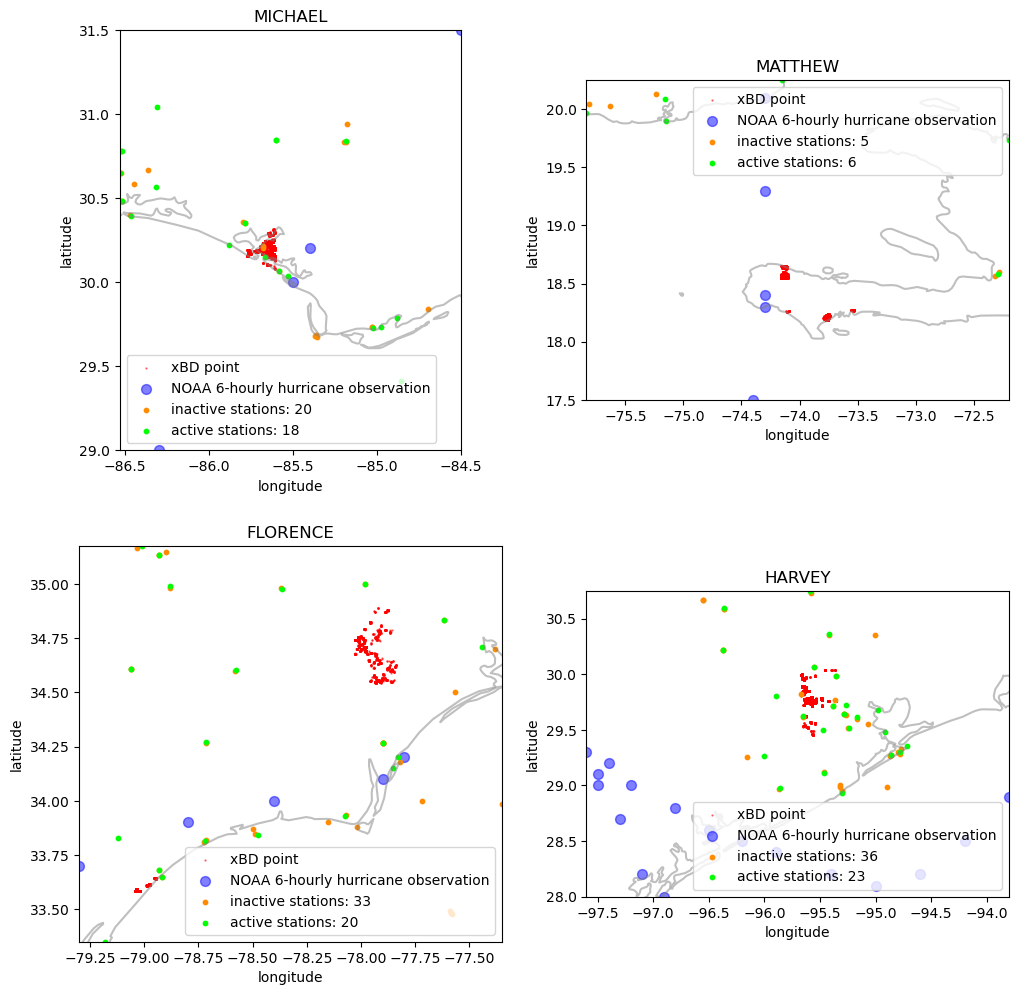

In [55]:
# plot all weather stations against hurricane track and xbd points, zoomed into area of interest
distance_buffer = 5

# BY EVENT
# plot xbd locations and relevant NOAA datapoints
fig, axs = plt.subplots(2,2,figsize=[12,12]);
axs = axs.ravel()

# format plot size
plt.rcParams['figure.figsize'] = [13, 7]

for i,name in enumerate(xbd_hurricane_names):
    axs[i].set_title(f'{name}')
    axs[i].set_xlabel('longitude'), axs[i].set_ylabel('latitude')
    gdf_coastlines.plot(ax=axs[i],color='grey',alpha=0.5)

    # xbd observations
    gdf_xbd_points = gpd.GeoDataFrame(df_xbd_points[df_xbd_points['disaster_name']==name])
    gdf_xbd_points.plot(ax=axs[i],color='red',markersize=0.5,alpha=0.5,label='xBD point');

    # noaa 6-hourly weather observations
    gdf_xbd_hurricanes_noaa = gpd.GeoDataFrame(df_xbd_hurricanes_noaa[df_xbd_hurricanes_noaa['name']==name])
    gdf_xbd_hurricanes_noaa.plot(ax=axs[i],color='blue',markersize=50,alpha=0.5,label='NOAA 6-hourly hurricane observation');

    # calculate average lat-lon 
    av_lat,av_lon = gtc_functions.calcDfColMeanValues(gdf_xbd_points,['lat','lon'])
    # weather stations
    gdf_event_stations = gtc_functions.limitDfSpatially(gdf_stations,[av_lat,av_lon],distance_buffer)

    # inactive weather stations
    gdf_event_stations_inactive = gtc_functions.station_availability(gdf_event_stations,gdf_xbd_hurricanes_noaa,available=False)
    gdf_event_stations_inactive.plot(ax=axs[i],color='darkorange',markersize=10,label=f'inactive stations: {len(gdf_event_stations_inactive)}')

    # active weather stations
    gdf_event_stations_active = gtc_functions.station_availability(gdf_event_stations,gdf_xbd_hurricanes_noaa,available=True)
    gdf_event_stations_active.plot(ax=axs[i],color='lime',markersize=10,alpha=1,label=f'active stations: {len(gdf_event_stations_active)}')

    # ensure that at least 3 hurricane observation points are in the image
    limited_weather_points = gtc_functions.limitDfSpatially(gdf_xbd_hurricanes_noaa,[av_lat,av_lon],min_number=3)
    # generate list of observation coordinates, zoomed on xbd points region
    coords = list(gdf_xbd_points['geometry'])+list(gdf_event_stations['geometry'])+list(limited_weather_points['geometry'])
    lats = [pt.y for pt in coords]
    lons = [pt.x for pt in coords]
    # restrict axes limits to zoom in on available data
    axs[i].set_ylim(min(lats),max(lats))
    axs[i].set_xlim(min(lons),max(lons))
    axs[i].legend()


The CMORPH weather data is at a consistent 0.25 degree resolution for all geographical regions. Using this avoids the varying proximity of weather stations to the xBD datapoints seen above, and bypasses the data interpolation steps necessary to get the weather station data into a workable format. 

The poor data seen in the weather stations data raises questions as to the validity of GaLeNet's use of the same data via the OpenWeatherMap API...

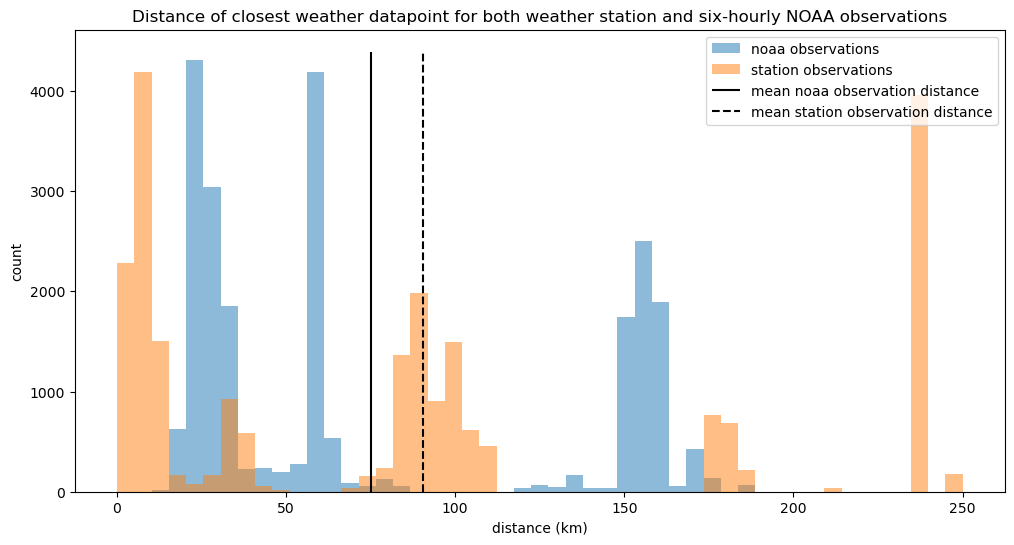

In [41]:
# compare distances between NOAA observations and weather station observations
# relative to xbd points

# calculate average distances
av_noaa_xbd_distance = df_noaa_xbd_weather['shortest_distance_to_track'].mean()
av_station_distance = df_stations_xbd['distance_to_closest'].mean()

fig,ax_hist = plt.subplots(figsize=[12,6])

# plot histogram
bins = np.linspace(0,250,50)
n_noaa,_,_ = ax_hist.hist(df_noaa_xbd_weather['shortest_distance_to_track'],bins,alpha=0.5,label='noaa observations');
n_stations,_,_ = ax_hist.hist(df_stations_xbd['distance_to_closest'],bins,alpha=0.5,label='station observations');

# plot means
ax_hist.vlines(av_noaa_xbd_distance,ymin=0,ymax=np.max(n_noaa+n_stations),color='k',label='mean noaa observation distance')
ax_hist.vlines(av_station_distance,ymin=0,ymax=np.max(n_noaa+n_stations),color='k',ls='--',label='mean station observation distance')

# formatting
ax_hist.set_title('Distance of closest weather datapoint for both weather station and six-hourly NOAA observations')
ax_hist.set_xlabel('distance (km)'), ax_hist.set_ylabel('count')
ax_hist.legend(loc='upper right');


The histogram above shows that the weather stations are on average further from the xBD observations than the NOAA observations, even though there is a relatively large number of very close stations. This may well be because for some events (likely Hurricane Matthew) had very few nearby stations. This is telling of the inequality of infrastructure between the US and the Caribbean islands. Yet another reason to use geography-agnostic CMORPH data.

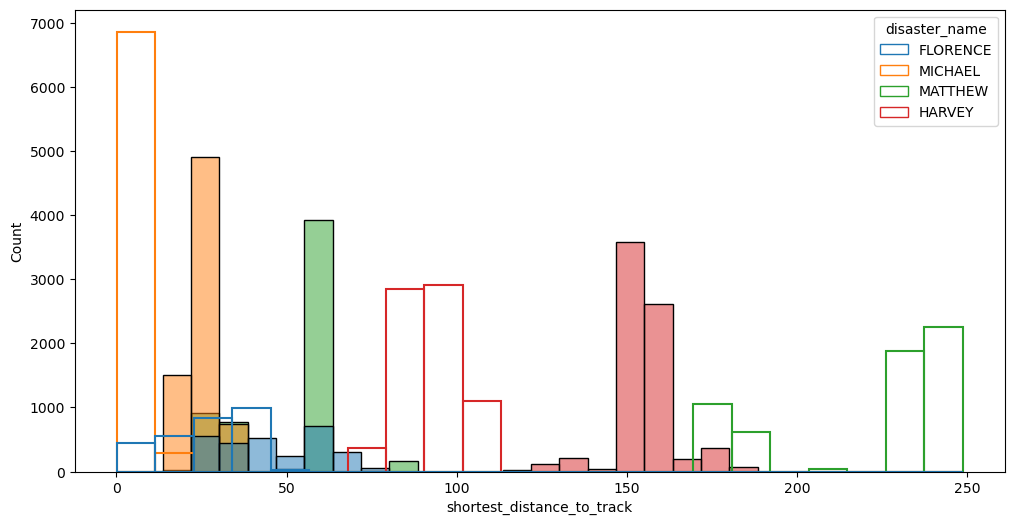

In [48]:
fig,ax_event_hist = plt.subplots(figsize=[12,6])

# TODO: break down histogram by event
sns.histplot(ax=ax_event_hist,data=df_noaa_xbd_weather,x='shortest_distance_to_track',hue='name');
sns.histplot(ax=ax_event_hist,data=df_stations_xbd,x='distance_to_closest',hue='disaster_name',fill=False);


In [ ]:
# TODO: animate HURDAT best track data